In [3]:
import pandas as pd, numpy as np
from scipy.stats import skew, kurtosis
import numpy as np
import plotly.express as px
import time

In [4]:
def iqr_approach(series, feature, k:float):
    summary = series.describe()
    return pd.DataFrame({
        'feature': [feature],
        'lower_bound_iqr': round(summary['25%'] - k * (summary['75%'] - summary['25%']), 2),
        'upper_bound_iqr': round(summary['75%'] + k * (summary['75%'] - summary['25%']), 2)
    })

def std_approach(series, feature, alpha: float):
    summary = series.describe()
    return pd.DataFrame({
        'feature': [feature],
        'lower_bound_std': round(summary['mean'] - alpha * summary['std'], 2),
        'upper_bound_std': round(summary['mean'] + alpha * summary['std'], 2)
    })

def modified_z_score_approach(series, feature, threshold: float = 3.5):
    median = series.median()
    
    absolute_deviations = np.abs(series - median)
    mad = absolute_deviations.median()

    lower_bound = round(median - (threshold * mad / 0.6745), 2)
    upper_bound = round(median + (threshold * mad / 0.6745), 2)

    # Ergebnisse als DataFrame zurückgeben
    return pd.DataFrame({
        'feature': [feature],
        'lower_bound_mod_z_score': [lower_bound],
        'upper_bound_mod_z_score': [upper_bound]
    })
    

def gamma_method_modified(series, feature, alphas: int = 6, alphak: int = 30, beta_1=2, beta_2=2, gamma=2):
    
    mean = series.mean()
    sigma = series.std()

    z_scores = (series - mean) / sigma

    skew_result, kurt_result = abs(skew(z_scores)), abs(kurtosis(z_scores))
    if skew_result < alphas and kurt_result < alphak:
        return pd.DataFrame({
        'feature': [feature],
        'lower_bound_gamma': round(mean - beta_1 * sigma,2),
        'upper_bound_gamma': round(mean + beta_2 * sigma,2)
        })
    else:   
        return pd.DataFrame({
            'feature': [feature],
            'lower_bound_gamma': round(mean - gamma * beta_1 * sigma,2),
            'upper_bound_gamma': round(mean + gamma * beta_2 * sigma,2)
        })


def jaccard_index(lower_a, upper_a, lower_b, upper_b):
    overlap = max(0, min(upper_b, upper_a) - max(lower_b, lower_a))
    distance = max(0, max(upper_b, upper_a) - min(lower_b, lower_a))
    
    return overlap / distance if distance != 0 else 0

In [5]:
np.random.seed(42)

num_features = 20  
num_data_points = 500  
num_anomalies = 50  


data = {}
min_values = []
max_values = []

for i in range(1, num_features + 1):
    feature_name = f'Feature_{i}'
    normal_data = np.random.normal(loc=10, scale=5, size=num_data_points)
    min_values.append(np.min(normal_data))  
    max_values.append(np.max(normal_data))  
    anomalies = np.random.uniform(low=50, high=100, size=num_anomalies)
    combined_data = np.concatenate([normal_data, anomalies]) 
    data[feature_name] = combined_data
features_list = []
values_list = []

for feature in data:
    features_list.append(feature)
    values_list.append(data[feature].tolist()) 

final_df = pd.DataFrame({
    'feature': features_list,
    'values': values_list,
    'lower': min_values,
    'upper': max_values
})

final_df

,feature,values,lower,upper
0,Feature_1,"[12.483570765056164, 9.308678494144077, 13.238...",-6.206337,29.263657
1,Feature_2,"[14.178460560325709, 4.3514657267119095, 12.64...",-3.484433,23.161910
2,Feature_3,"[8.391824743913087, 20.383739917804206, 11.909...",-4.481277,23.008416
3,Feature_4,"[10.566352052688822, 2.8086101084131663, 14.59...",-5.097561,25.688743
4,Feature_5,"[3.699176174137099, 6.918192959802613, 8.12401...",-3.178739,25.549593
5,Feature_6,"[4.916584357117514, 8.779597631628993, 9.80346...",-4.955680,29.631189
6,Feature_7,"[5.765745169373177, 16.248094526483335, 13.896...",-4.647243,26.215465
7,Feature_8,"[11.38679230982338, 9.888605104081433, 11.6104...",-5.038162,25.760284
8,Feature_9,"[16.033040774319574, 2.364160717051762, 4.7245...",-5.883519,23.776089
9,Feature_10,"[12.939279440688676, 13.098693923514343, 0.443...",-3.124085,25.564551


In [25]:
error_tracking = []

iqr_params = {'k': [1, 1.5, 2, 2.5, 3, 3.5]}
std_params = {'alpha': [1, 1.5, 2, 2.5, 3, 3.5]}
modified_z_params = {'alpha': [1, 1.5, 2, 2.5, 3, 3.5, 4]}
gamma_params = {
    'alpha_s': [3,6], 
    'alpha_k': [15, 30], 
    'beta_1': [2, 3], 
    'beta_2': [2, 3], 
    'gamma': [2]
}

final_results = []

best_iqr_params = {}
best_std_params = {}
best_mod_z_params = {}
best_gamma_params = {}

start_time = time.time()

for index, row in final_df.iterrows():
    values_series = pd.Series(row['values'])
    feature = row['feature']
    baseline_bounds = (row['lower'], row['upper'])
    
    best_iqr, best_std, best_mod_z, best_gamma = None, None, None, None
    best_iqr_score, best_std_score, best_mod_z_score, best_gamma_score = -float('inf'), -float('inf'), -float('inf'), -float('inf')

    # Grid search for IQR
    for step, k in enumerate(iqr_params['k']):
        filter_row_iqr = iqr_approach(values_series, feature, k)
        lower, upper = filter_row_iqr['lower_bound_iqr'].iloc[0], filter_row_iqr['upper_bound_iqr'].iloc[0]
        score = jaccard_index(lower, upper, baseline_bounds[0], baseline_bounds[1])
        error_tracking.append({'step': step, 'method': 'IQR', 'error': 1 - score, 'feature': feature, 'parameter': k})
        if score > best_iqr_score:
            best_iqr_score = score
            best_iqr = filter_row_iqr
            best_iqr_params = {'k': k}  

    # Grid search for Standard Deviation
    for step, alpha in enumerate(std_params['alpha']):
        filter_row_std = std_approach(values_series, feature, alpha)
        lower, upper = filter_row_std['lower_bound_std'].iloc[0], filter_row_std['upper_bound_std'].iloc[0]
        score = jaccard_index(lower, upper, baseline_bounds[0], baseline_bounds[1])
        error_tracking.append({'step': step, 'method': 'STD', 'error': 1 - score, 'feature': feature, 'parameter': alpha})
        if score > best_std_score:
            best_std_score = score
            best_std = filter_row_std
            best_std_params = {'alpha': alpha}  

    # Grid search for Modified Z-Score
    for step, alpha in enumerate(modified_z_params['alpha']):
        filter_row_mod_z = modified_z_score_approach(values_series, feature, alpha)
        lower, upper = filter_row_mod_z['lower_bound_mod_z_score'].iloc[0], filter_row_mod_z['upper_bound_mod_z_score'].iloc[0]
        score = jaccard_index(lower, upper, baseline_bounds[0], baseline_bounds[1])
        error_tracking.append({'step': step, 'method': 'MOD_Z', 'error': 1 - score, 'feature': feature, 'parameter': alpha})
        if score > best_mod_z_score:
            best_mod_z_score = score
            best_mod_z = filter_row_mod_z
            best_mod_z_params = {'alpha': alpha}  

    # Grid search for Gamma Approach
    step = 0
    for alpha_s in gamma_params['alpha_s']:
        for alpha_k in gamma_params['alpha_k']:
            for beta_1 in gamma_params['beta_1']:
                for beta_2 in gamma_params['beta_2']:
                    for gamma in gamma_params['gamma']:
                        filter_row_gamma = gamma_method_modified(values_series, feature, alpha_s, alpha_k, beta_1, beta_2, gamma)
                        if filter_row_gamma is not None:
                            lower, upper = filter_row_gamma['lower_bound_gamma'].iloc[0], filter_row_gamma['upper_bound_gamma'].iloc[0]
                            score = jaccard_index(lower, upper, baseline_bounds[0], baseline_bounds[1])
                            error_tracking.append({'step': step, 'method': 'GAMMA', 'error': 1 - score, 'feature': feature, 'parameter': (alpha_s, alpha_k, beta_1, beta_2, gamma)})
                            if score > best_gamma_score:
                                best_gamma_score = score
                                best_gamma = filter_row_gamma
                                best_gamma_params = {
                                    'alpha_s': alpha_s, 
                                    'alpha_k': alpha_k, 
                                    'beta_1': beta_1, 
                                    'beta_2': beta_2, 
                                    'gamma': gamma
                                }  
                            step += 1

    result = {
        'feature': feature,
        'values': row['values'],
        'lower': row['lower'],
        'upper': row['upper'],
        'lower_bound_iqr': best_iqr['lower_bound_iqr'].iloc[0] if best_iqr is not None else None,
        'upper_bound_iqr': best_iqr['upper_bound_iqr'].iloc[0] if best_iqr is not None else None,
        'lower_bound_std': best_std['lower_bound_std'].iloc[0] if best_std is not None else None,
        'upper_bound_std': best_std['upper_bound_std'].iloc[0] if best_std is not None else None,
        'lower_bound_mod_z_score': best_mod_z['lower_bound_mod_z_score'].iloc[0] if best_mod_z is not None else None,
        'upper_bound_mod_z_score': best_mod_z['upper_bound_mod_z_score'].iloc[0] if best_mod_z is not None else None,
        'lower_bound_gamma': best_gamma['lower_bound_gamma'].iloc[0] if best_gamma is not None else None,
        'upper_bound_gamma': best_gamma['upper_bound_gamma'].iloc[0] if best_gamma is not None else None,
        'IQR': best_iqr_score,
        'STD': best_std_score,
        'MOD_Z': best_mod_z_score,
        'GAMMA': best_gamma_score,
        'best_iqr_params': best_iqr_params,  
        'best_std_params': best_std_params,  
        'best_mod_z_params': best_mod_z_params, 
        'best_gamma_params': best_gamma_params 
    }
    final_results.append(result)

final_df_result = pd.DataFrame(final_results)

end_time = time.time()

error_df = pd.DataFrame(error_tracking)

In [26]:
elapsed_time = (end_time - start_time)/60

print(f"Elapsed time: {elapsed_time:.2f} minutes")

Elapsed time: 0.02 minutes


In [27]:
error_df

,step,method,error,feature,parameter
0,0,IQR,0.383423,Feature_1,1
1,1,IQR,0.177897,Feature_1,1.5
2,2,IQR,0.047968,Feature_1,2
3,3,IQR,0.189072,Feature_1,2.5
4,4,IQR,0.304783,Feature_1,3
...,...,...,...,...,...
695,11,GAMMA,0.751483,Feature_20,"(6, 15, 3, 3, 2)"
696,12,GAMMA,0.627209,Feature_20,"(6, 30, 2, 2, 2)"
697,13,GAMMA,0.701775,Feature_20,"(6, 30, 2, 3, 2)"
698,14,GAMMA,0.701775,Feature_20,"(6, 30, 3, 2, 2)"


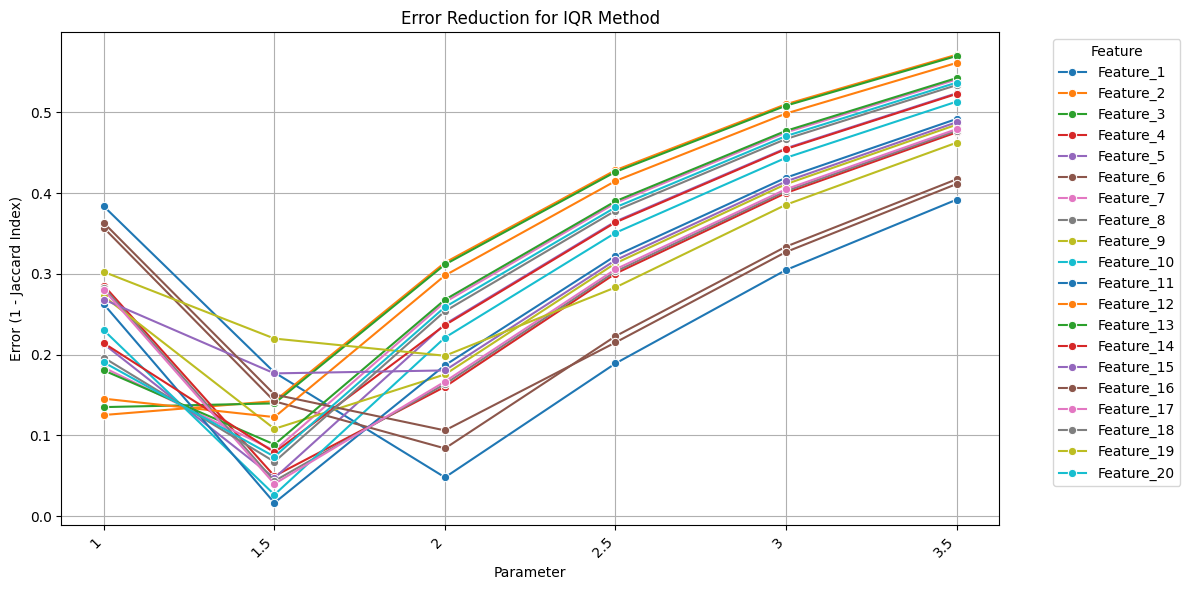

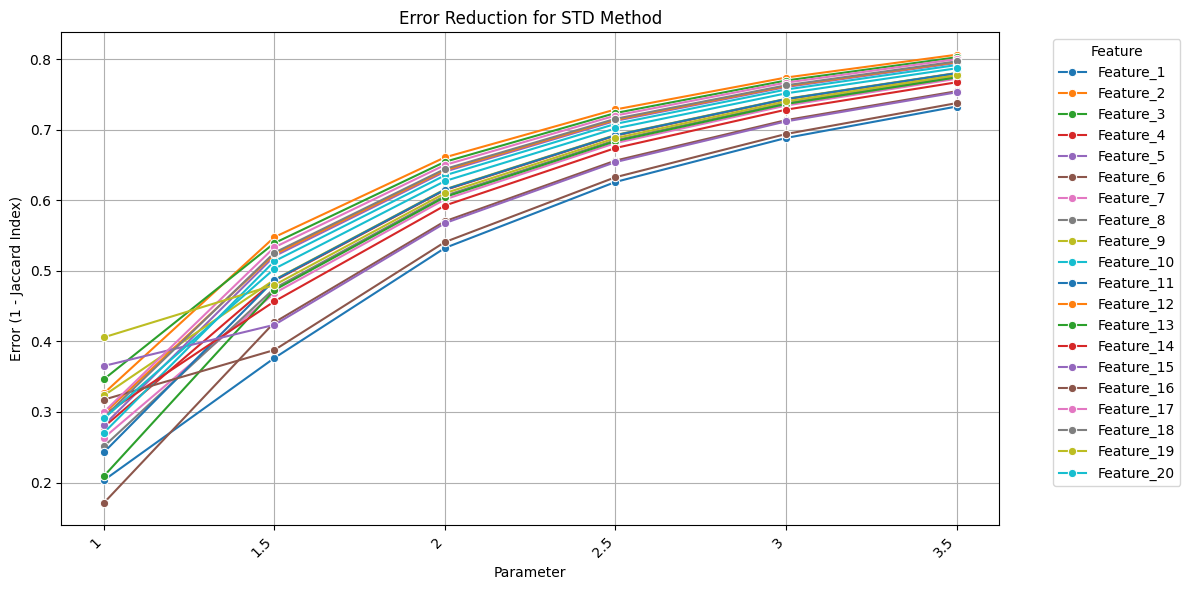

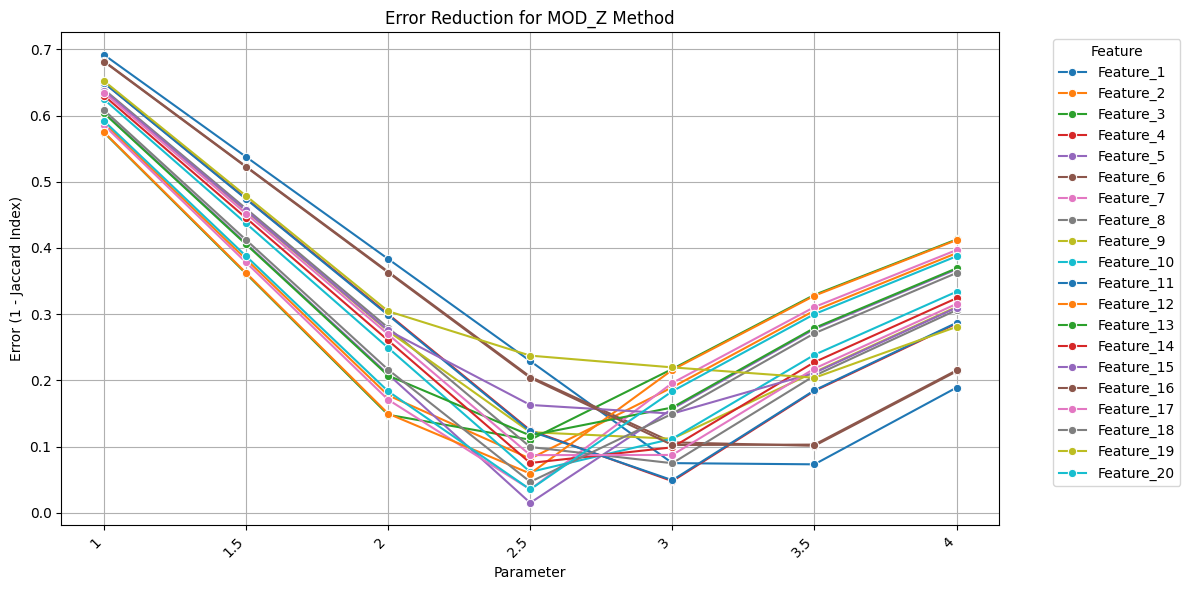

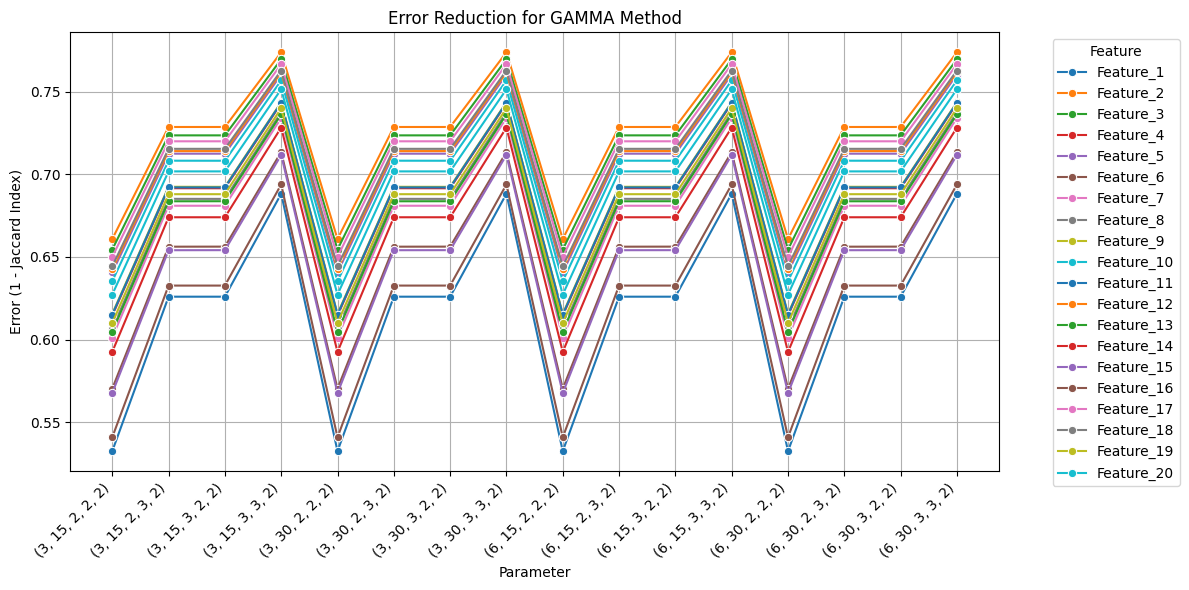

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert parameter column to string for better indexing
error_df['parameter'] = error_df['parameter'].astype(str)

# Plot each method separately
methods = error_df['method'].unique()

for method in methods:
    method_df = error_df[error_df['method'] == method]
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=method_df,
        x='parameter',
        y='error',
        hue='feature',
        marker='o',
        palette='tab10'
    )
    
    plt.title(f"Error Reduction for {method} Method")
    plt.xlabel("Parameter")
    plt.ylabel("Error (1 - Jaccard Index)")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [29]:
final_df_result.head()


,feature,values,lower,upper,lower_bound_iqr,upper_bound_iqr,lower_bound_std,upper_bound_std,lower_bound_mod_z_score,upper_bound_mod_z_score,lower_bound_gamma,upper_bound_gamma,IQR,STD,MOD_Z,GAMMA,best_iqr_params,best_std_params,best_mod_z_params,best_gamma_params
0,Feature_1,"[12.483570765056164, 9.308678494144077, 13.238...",-6.206337,29.263657,-7.58,28.87,-3.28,34.64,-8.56,29.71,-22.25,53.61,0.952032,0.796734,0.926835,0.467572,{'k': 2},{'alpha': 1},{'alpha': 3.5},"{'alpha_s': 3, 'alpha_k': 15, 'beta_1': 2, 'be..."
1,Feature_2,"[14.178460560325709, 4.3514657267119095, 12.64...",-3.484433,23.161910,-0.36,22.95,-3.37,35.91,-2.71,24.69,-23.01,55.55,0.874792,0.673494,0.918276,0.339185,{'k': 1},{'alpha': 1},{'alpha': 2.5},"{'alpha_s': 3, 'alpha_k': 15, 'beta_1': 2, 'be..."
2,Feature_3,"[8.391824743913087, 20.383739917804206, 11.909...",-4.481277,23.008416,-0.85,23.10,-3.58,36.20,-3.71,25.55,-23.47,56.09,0.865022,0.653579,0.889686,0.345522,{'k': 1},{'alpha': 1},{'alpha': 2.5},"{'alpha_s': 3, 'alpha_k': 15, 'beta_1': 2, 'be..."
3,Feature_4,"[10.566352052688822, 2.8086101084131663, 14.59...",-5.097561,25.688743,-3.60,25.72,-3.94,35.99,-5.44,26.89,-23.90,55.95,0.950391,0.721112,0.952252,0.385552,{'k': 1.5},{'alpha': 1},{'alpha': 3},"{'alpha_s': 3, 'alpha_k': 15, 'beta_1': 2, 'be..."
4,Feature_5,"[3.699176174137099, 6.918192959802613, 8.12401...",-3.178739,25.549593,-4.34,25.81,-3.87,36.10,-3.23,25.17,-23.85,56.08,0.952847,0.718747,0.985029,0.359419,{'k': 1.5},{'alpha': 1},{'alpha': 2.5},"{'alpha_s': 3, 'alpha_k': 15, 'beta_1': 2, 'be..."


In [30]:
length_df = len(final_df_result)

iqr_mean = final_df_result['IQR'].sum() / length_df
z_score_mean = final_df_result['STD'].sum() / length_df
mod_z_mean = final_df_result['MOD_Z'].sum() / length_df
gamma_mean = final_df_result['GAMMA'].sum() / length_df

df_eval = pd.DataFrame({
    'IQR': [iqr_mean],
    'STD': [z_score_mean],
    'MOD_Z': [mod_z_mean],
    'GAMMA': [gamma_mean]
}, index=['mean jaccard coeff'])

In [31]:
df_jaccard = final_df_result.iloc[:, -8:-4]

fig = px.imshow(df_jaccard, 
                text_auto=".2f",  
                color_continuous_scale="YlGnBu", 
                labels=dict(color="Jaccard Index")) 

fig.update_layout(
    title="Jaccard Index Heatmap",
    xaxis_title="Methods",
    yaxis_title="Features",
    yaxis=dict(tickmode='array', tickvals=list(range(len(df_jaccard))), ticktext=[f'Feature {i+1}' for i in range(len(df_jaccard))])
)


fig.show()


In [14]:
df_eval

,IQR,STD,MOD_Z,GAMMA
mean jaccard coeff,0.914162,0.713323,0.918102,0.388693


In [15]:
best_method = df_eval.idxmax(axis=1)

In [16]:
print(f'Best Method based on labeled data: {best_method.values[0]}')

Best Method based on labeled data: MOD_Z


In [17]:
values = [d['k'] for d in final_df_result['best_iqr_params'] if 'k' in d]

In [18]:
from statistics import mode
mode_value_k = mode(values)

In [19]:
mode_value_k

1.5

In [19]:
results_best_approach = pd.DataFrame()

for index, row in final_df.iterrows():
    values_series = pd.Series(row['values'])
    feature = row['feature']
    baseline_bounds = (row['lower'], row['upper'])
    
    best_results = iqr_approach(values_series, feature, mode_value_k)
    
    if best_results is not None:
        lower_bound_iqr = best_results['lower_bound_iqr'].iloc[0]
        upper_bound_iqr = best_results['upper_bound_iqr'].iloc[0]

        baseline_lower, baseline_upper = baseline_bounds

        score = jaccard_index(lower_bound_iqr, upper_bound_iqr, baseline_lower, baseline_upper)

        results = {
            'feature': feature,
            'values': values_series.tolist(),  
            'lower_bound_gamma': lower_bound_iqr,
            'upper_bound_gamma': upper_bound_iqr,
            'baseline_lower': baseline_lower,
            'baseline_upper': baseline_upper,
            'jaccard_score': score
        }

        iqr_results_df = pd.DataFrame([results])

        results_best_approach = pd.concat([results_best_approach, iqr_results_df], ignore_index=True)

results_best_approach


,feature,values,lower_bound_gamma,upper_bound_gamma,baseline_lower,baseline_upper,jaccard_score
0,Feature_1,"[12.483570765056164, 9.308678494144077, 13.238...",-3.94,25.22,-6.206337,29.263657,0.822103
1,Feature_2,"[14.178460560325709, 4.3514657267119095, 12.64...",-4.24,26.83,-3.484433,23.161910,0.857623
2,Feature_3,"[8.391824743913087, 20.383739917804206, 11.909...",-4.85,27.10,-4.481277,23.008416,0.860397
3,Feature_4,"[10.566352052688822, 2.8086101084131663, 14.59...",-3.60,25.72,-5.097561,25.688743,0.950391
4,Feature_5,"[3.699176174137099, 6.918192959802613, 8.12401...",-4.34,25.81,-3.178739,25.549593,0.952847
5,Feature_6,"[4.916584357117514, 8.779597631628993, 9.80346...",-4.07,25.60,-4.955680,29.631189,0.857840
6,Feature_7,"[5.765745169373177, 16.248094526483335, 13.896...",-5.56,28.03,-4.647243,26.215465,0.918806
7,Feature_8,"[11.38679230982338, 9.888605104081433, 11.6104...",-4.21,25.25,-5.038162,25.760284,0.956542
8,Feature_9,"[16.033040774319574, 2.364160717051762, 4.7245...",-3.77,25.00,-5.883519,23.776089,0.891935
9,Feature_10,"[12.939279440688676, 13.098693923514343, 0.443...",-3.78,25.69,-3.124085,25.564551,0.973486


In [20]:
df_jaccard['IQR with best params'] = results_best_approach['jaccard_score']

In [21]:
df_jaccard

,IQR,STD,MOD_Z,GAMMA,IQR with best params
0,0.952032,0.796734,0.926835,0.467572,0.822103
1,0.874792,0.673494,0.918276,0.339185,0.857623
2,0.865022,0.653579,0.889686,0.345522,0.860397
3,0.950391,0.721112,0.952252,0.385552,0.950391
4,0.952847,0.718747,0.985029,0.359419,0.952847
5,0.916166,0.828807,0.898827,0.429757,0.857840
6,0.918806,0.736583,0.964761,0.398795,0.918806
7,0.956542,0.748729,0.925156,0.393590,0.956542
8,0.891935,0.676670,0.888200,0.384441,0.891935
9,0.973486,0.729434,0.938351,0.364717,0.973486


In [27]:
fig = px.imshow(df_jaccard, 
                text_auto=".2f",  
                color_continuous_scale="YlGnBu", 
                labels=dict(color="Jaccard Index")) 

fig.update_layout(
    title="Jaccard Index Heatmap",
    xaxis_title="Methods",
    yaxis_title="Features",
    yaxis=dict(tickmode='array', tickvals=list(range(len(df_jaccard))), ticktext=[f'Feature {i+1}' for i in range(len(df_jaccard))])
)


fig.show()